# Mobile Phone Price Prediction using Machine Learning

## Step 1: Importing Required Libraries and Models


In [39]:
# ============================
# Import Required Libraries
# ============================

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import re

# Preprocessing & Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Tabular Results
from tabulate import tabulate

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Step 2: Data Collection 

In [40]:
data = pd.read_csv('mobiles_dataset_2025.csv', encoding='latin1')

In [41]:
# data = data[['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)']]
data.shape

(930, 11)

## Step 3: Data Preprocessing

In [42]:
# Check for null value
data.isnull().sum()

Company Name            0
Model Name              0
Mobile Weight           0
RAM                     0
Front Camera            0
Back Camera             0
Processor               0
Battery Capacity        0
Screen Size             0
Launched Price (USA)    0
Launched Year           0
dtype: int64

In [43]:
# Helper function to clean numeric columns
def clean_numeric(series, remove_str="", round_to_int=False):
    cleaned = (
        series.astype(str)
        .str.replace(remove_str, "", regex=False)
        .str.replace("Not available", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.extract(r"(\d+\.?\d*)")[0]   
    )
    cleaned = pd.to_numeric(cleaned, errors="coerce")
    
    if round_to_int:
        cleaned = cleaned.round().astype("Int64")  
    return cleaned

def extract_rom(model_name):
    model_name = str(model_name).upper()
    match_tb = re.search(r'(\d+)TB', model_name)
    if match_tb:
        return float(match_tb.group(1)) / 64 * 1024
    match_gb = re.search(r'(\d+)GB', model_name)
    if match_gb:
        return float(match_gb.group(1)) / 64
    return np.nan

print("Columns:", data.columns.tolist())

# RAM
if "RAM" in data.columns:
    data["RAM"] = clean_numeric(data["RAM"], remove_str="GB", round_to_int=True)

# ROM
data['ROM'] = data['Model Name'].apply(extract_rom).apply(lambda x: x if not pd.isna(x) else np.nan)

data['ROM'] = data['ROM'].astype('Float64')
data['ROM'] = data['ROM'].fillna(data['ROM'].median())

# # Front Camera
if "Front Camera" in data.columns:
    data["Front Camera"] = clean_numeric(data["Front Camera"], remove_str="MP") / 10

# Back Camera
if "Back Camera" in data.columns:
    data["Back Camera"] = clean_numeric(data["Back Camera"], remove_str="MP") / 10

# Rear / Primary Camera (handle whichever exists)
for cam_col in ["Primary Camera", "Rear Camera", "Main Camera"]:
    if cam_col in data.columns:
        data[cam_col] = clean_numeric(data[cam_col], remove_str="MP")

# Battery
if "Battery Capacity" in data.columns:
    data["Battery Capacity"] = clean_numeric(data["Battery Capacity"], remove_str="mAh", round_to_int=True)
    data["Battery Capacity"] = data["Battery Capacity"] / 1000
if "Internal Storage" in data.columns:
    data["Internal Storage"] = clean_numeric(data["Internal Storage"], remove_str="GB", round_to_int=True)

# Screen Size
if "Screen Size" in data.columns:
    data["Screen Size"] = clean_numeric(data["Screen Size"], remove_str="inches")

# company Name
if 'Company Name' in data.columns:
    # decrease amount of Company Name only Apple, Samsung, Oppo, Honor
    company_counts = data['Company Name'].value_counts()
    
    top_companies = company_counts.head(5).index
    
    data['Company Simplified'] = data['Company Name'].apply(lambda x: x if x in top_companies else 'Other')
    
    # One-hot encode lại
    data = pd.get_dummies(data, columns=['Company Simplified'], prefix='Company', drop_first=False, dtype=int)

if "Processor" in data.columns:
    processor_texts = data["Processor"].fillna("").astype(str)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=30)
    processor_tfidf = vectorizer.fit_transform(processor_texts)

    # Giảm còn 3 chiều đặc trưng
    pca = PCA(n_components=3, random_state=42)
    processor_pca = pca.fit_transform(processor_tfidf.toarray())

    processor_df = pd.DataFrame(
        processor_pca, columns=["Processor_vec1", "Processor_vec2", "Processor_vec3"]
    )

    data = pd.concat([data.reset_index(drop=True), processor_df], axis=1)

print(data.columns)

def clean_usa_price(price_str):
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str).strip()
    
    price_str = price_str.replace("USD", "").replace("$", "").strip()
    
    price_str = price_str.replace(" ", "")
    
    if price_str in ["", "Not available", "not available", "N/A", "None"]:
        return np.nan
    
    try:
        comma_count = price_str.count(',')
        
        if comma_count == 0:
            return float(price_str)
        elif comma_count == 1:
            comma_pos = price_str.index(',')
            digits_after = len(price_str) - comma_pos - 1
            
            if digits_after == 2:
                price_str = price_str.replace(',', '.')
            else:
                price_str = price_str.replace(',', '')
        else:
            price_str = price_str.replace(',', '')
        
        value = float(price_str)
        
        if 99 <= value <= 2000:
            return value
        else:
            return np.nan 
    except:
        return np.nan

# clean Launch price USA
if "Launched Price (USA)" in data.columns:
    print("Cleaning USA prices...")
    print(f"Before: {data['Launched Price (USA)'].head(10).tolist()}")

    data["Launched Price (USA)"] = data["Launched Price (USA)"].apply(clean_usa_price) / 100

    print(f"After: {data['Launched Price (USA)'].head(10).tolist()}")
    print(f"\nUSA Price Statistics:")
    print(data["Launched Price (USA)"].describe())
    print(f"\nInvalid/Placeholder values: {data['Launched Price (USA)'].isna().sum()}")


Columns: ['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)', 'Launched Year']
Index(['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera',
       'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size',
       'Launched Price (USA)', 'Launched Year', 'ROM', 'Company_Apple',
       'Company_Honor', 'Company_Oppo', 'Company_Other', 'Company_Samsung',
       'Company_Vivo', 'Processor_vec1', 'Processor_vec2', 'Processor_vec3'],
      dtype='object')
Cleaning USA prices...
Before: ['USD 799', 'USD 849', 'USD 899', 'USD 899', 'USD 949', 'USD 999', 'USD 999', 'USD 1,049', 'USD 1,099', 'USD 1,099']
After: [7.99, 8.49, 8.99, 8.99, 9.49, 9.99, 9.99, 10.49, 10.99, 10.99]

USA Price Statistics:
count    923.000000
mean       5.684192
std        3.857445
min        0.790000
25%        2.500000
50%        4.490000
75%        7.990000
max       18.990000
Name: Launched Pric

In [44]:
data.describe()

,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,930.0,930.000000,930.00000,930.0,930.000000,923.000000,930.000000,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,9.300000e+02,9.300000e+02,9.300000e+02
mean,7.786022,1.816301,4.67643,5.026163,7.083796,5.684192,2022.193548,3.107258,0.104301,0.097849,0.138710,0.472043,0.094624,0.092473,-7.640244e-16,-1.222439e-16,-2.674086e-16
std,3.177629,1.198623,3.10699,1.355548,1.533690,3.857445,1.862080,2.271735,0.305815,0.297271,0.345829,0.499486,0.292852,0.289849,4.262734e-01,2.988981e-01,2.751127e-01
min,1.0,0.200000,0.50000,2.0,5.000000,0.790000,2014.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.504965e-01,-7.102952e-01,-5.199964e-01
25%,6.0,0.800000,1.60000,4.4025,6.500000,2.500000,2021.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.038693e-01,-1.058121e-01,-1.465504e-01
50%,8.0,1.600000,5.00000,5.0,6.670000,4.490000,2023.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.921112e-02,5.097489e-02,-2.363566e-02
75%,8.0,3.200000,5.00000,5.09125,6.780000,7.990000,2024.000000,4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.586492e-01,1.931551e-01,3.091909e-02
max,16.0,6.000000,20.00000,11.2,14.600000,18.990000,2025.000000,32.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.284119e-01,4.572660e-01,7.475682e-01


In [45]:
# Remove the duplicate values
data.drop_duplicates(inplace=True)
data.shape
data.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (USA),...,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
0,Apple,iPhone 16 128GB,174g,6,1.2,4.8,A17 Bionic,3.6,6.1,7.99,...,2.0,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
1,Apple,iPhone 16 256GB,174g,6,1.2,4.8,A17 Bionic,3.6,6.1,8.49,...,4.0,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
2,Apple,iPhone 16 512GB,174g,6,1.2,4.8,A17 Bionic,3.6,6.1,8.99,...,8.0,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
3,Apple,iPhone 16 Plus 128GB,203g,6,1.2,4.8,A17 Bionic,4.2,6.7,8.99,...,2.0,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391
4,Apple,iPhone 16 Plus 256GB,203g,6,1.2,4.8,A17 Bionic,4.2,6.7,9.49,...,4.0,1,0,0,0,0,0,-0.105389,-0.710295,-0.298391


## Step 4: Initial Data Exploration & Visualization

In [46]:
data.describe()

,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,915.0,915.000000,915.000000,915.0,915.000000,908.000000,915.000000,915.0,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,7.790164,1.816678,4.649158,5.030281,7.092678,5.737069,2022.205464,3.115574,0.106011,0.099454,0.125683,0.478689,0.096175,0.093989,0.000783,-0.001800,0.000320
std,3.189444,1.204347,3.112418,1.365572,1.544578,3.866057,1.869182,2.285632,0.308020,0.299434,0.331673,0.499819,0.294992,0.291973,0.426252,0.300214,0.275963
min,1.0,0.200000,0.500000,2.0,5.000000,0.790000,2014.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.650497,-0.710295,-0.519996
25%,6.0,0.800000,1.300000,4.4,6.500000,2.667500,2021.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.403869,-0.113062,-0.145094
50%,8.0,1.600000,5.000000,5.0,6.670000,4.490000,2023.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.089211,0.050975,-0.023636
75%,8.0,3.200000,5.000000,5.1,6.780000,8.115000,2024.000000,4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.458649,0.193155,0.030919
max,16.0,6.000000,20.000000,11.2,14.600000,18.990000,2025.000000,32.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.628412,0.457266,0.747568


Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): 0.034
    Launched Year  Launched Price (USA)
0            2014              1.690000
1            2016              2.110000
2            2017              5.056667
3            2018              6.309048
4            2019              6.094348
5            2020              5.853265
6            2021              5.013725
7            2022              5.806774
8            2023              5.909392
9            2024              5.884831
10           2025              4.286667


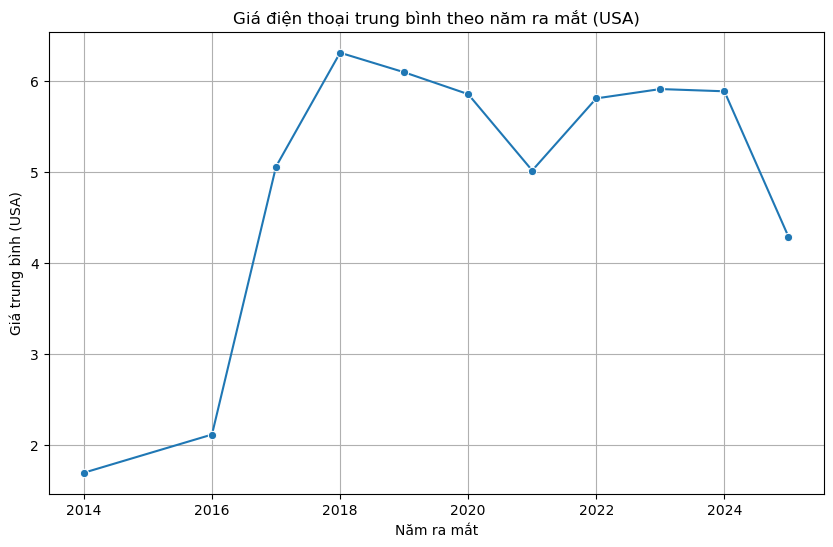

In [47]:
# Loại bỏ giá trị thiếu
df_filtered = data[['Launched Year', 'Launched Price (USA)']].dropna()

# Tính hệ số tương quan Pearson
correlation = df_filtered['Launched Year'].corr(df_filtered['Launched Price (USA)'])
print(f"Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): {correlation:.3f}")

# Tạo bảng trung bình giá theo năm ra mắt
summary = df_filtered.groupby('Launched Year')['Launched Price (USA)'].mean().reset_index()
print(summary)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='Launched Year', y='Launched Price (USA)', marker='o')
plt.title('Giá điện thoại trung bình theo năm ra mắt (USA)')
plt.xlabel('Năm ra mắt')
plt.ylabel('Giá trung bình (USA)')
plt.grid(True)
plt.show()

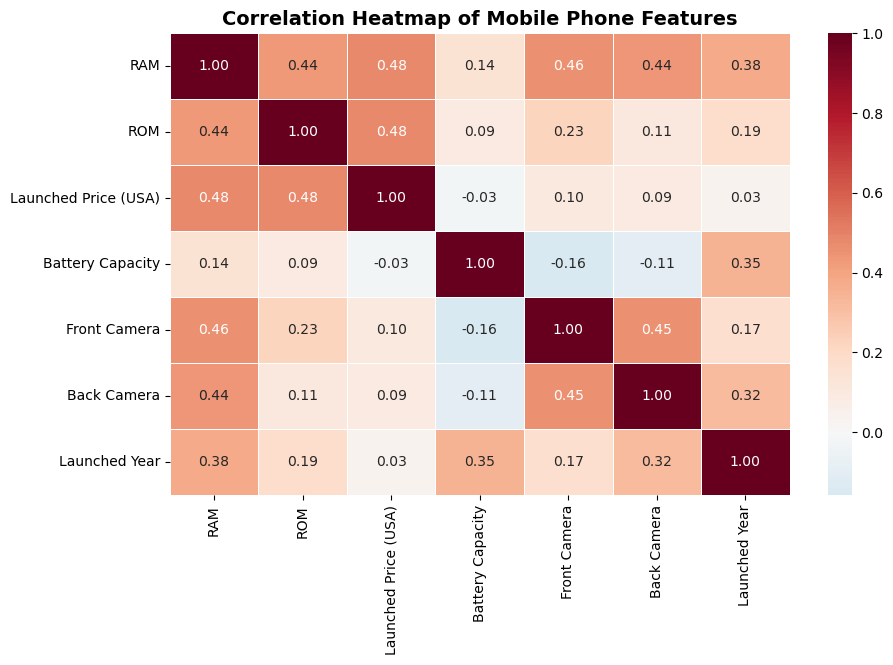

In [48]:
# Select only numerical columns
numeric_data = data[['RAM', 'ROM', 'Launched Price (USA)', 
                     'Battery Capacity', 'Front Camera', 'Back Camera', 'Launched Year']]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Mobile Phone Features", fontsize=14, fontweight="bold")
plt.show()


## Step 5: Train-Test Split

In [49]:
print("Handling missing values...")

for col in ['RAM', 'Front Camera', 'Back Camera'
            , 'Battery Capacity', 'Screen Size']:
    if data[col].isnull().any():
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)
        print(f"  {col}: Filled {data[col].isnull().sum()} NaNs with median {median_val:.2f}")

# Remove rows with NaN in target variable
data = data.dropna(subset=['Launched Price (USA)'])

# Remove duplicates
initial_shape = data.shape[0]
data = data.drop_duplicates()
print(f"\n✅ Removed {initial_shape - data.shape[0]} duplicate rows")
print(f"\nFinal shape: {data.shape}")
print(f"Missing values: {data.isnull().sum().sum()}")

final_df = data.copy()

Handling missing values...

✅ Removed 0 duplicate rows

Final shape: (908, 21)
Missing values: 0


In [50]:
# Drop rows where target variable is NaN
data = data.dropna(subset=['Launched Price (USA)'])

data = data.drop(['Model Name', 'Mobile Weight', 'Launched Year', 'Company Name', 'Processor'], axis=1)

X = data.drop(['Launched Price (USA)'], axis=1)
y = data['Launched Price (USA)']
# print(X)

data.to_csv('mobiles_dataset_2025_processed.csv', index=False)
print(data.columns)

Index(['RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 'Screen Size',
       'Launched Price (USA)', 'ROM', 'Company_Apple', 'Company_Honor',
       'Company_Oppo', 'Company_Other', 'Company_Samsung', 'Company_Vivo',
       'Processor_vec1', 'Processor_vec2', 'Processor_vec3'],
      dtype='object')


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
print(X.shape, X_train.shape, X_train.shape)
print(X_train.isnull().sum())

(908, 15) (726, 15) (726, 15)
RAM                 0
Front Camera        0
Back Camera         0
Battery Capacity    0
Screen Size         0
ROM                 0
Company_Apple       0
Company_Honor       0
Company_Oppo        0
Company_Other       0
Company_Samsung     0
Company_Vivo        0
Processor_vec1      0
Processor_vec2      0
Processor_vec3      0
dtype: int64


## Step 7: Standardize Data for KNeighborsRegressor & LR

In [53]:
# Standardized the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
print(np.isnan(X_train_scaled).sum())
print(np.isnan(X_test_scaled).sum())

0
0


## Step 8: Models Training and Evoluation

In [55]:
models_scaled = {
    "Linear Regression": LinearRegression(),
    "knn_model": KNeighborsRegressor(n_neighbors=5)
}

for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"{name}:")
    print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", round(r2_score(y_test, y_pred) * 100, 2), '%')
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print("=" * 30)


Linear Regression:
RMSE: 2.5080483974675323
R2 Score: 62.13 %
MAE:  1.8035601803193977
knn_model:
RMSE: 1.7820312553227713
R2 Score: 80.88 %
MAE:  1.1891264835164834


### ii.  Models That Do NOT Need Scaling:


In [56]:
# Define models with tuned parameters
models_unscaled = {
    "Decision Tree": DecisionTreeRegressor(
        max_depth=20,
        min_samples_split=15,
        min_samples_leaf=8,
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
}


# Train & evaluate each model once
for name, model in models_unscaled.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Regression metrics
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2 Score: {r2:.2f} %")
    print("=" * 50)


Decision Tree:
  RMSE: 1.80
  MAE: 1.27
  R2 Score: 80.48 %


Random Forest:
  RMSE: 1.38
  MAE: 0.95
  R2 Score: 88.61 %


## Models Performance 

In [57]:
# Store results in a list
results = []

# Unscaled models
for name, model in models_unscaled.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    results.append([name, rmse, mae, r2])

# Scaled models
for name, model in models_scaled.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100

    results.append([name, rmse, mae, r2])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2 Score (%)"])

# Sort by best R² score
results_df = results_df.sort_values(by="R2 Score (%)", ascending=False).reset_index(drop=True)

# Round values for readability
results_df["RMSE"] = results_df["RMSE"].round(2)
results_df["MAE"] = results_df["MAE"].round(2)
results_df["R2 Score (%)"] = results_df["R2 Score (%)"].round(2)

# Print as a clean professional table
print(tabulate(results_df, headers="keys", tablefmt="fancy_grid", showindex=False))


╒═══════════════════╤════════╤═══════╤════════════════╕
│ Model             │   RMSE │   MAE │   R2 Score (%) │
╞═══════════════════╪════════╪═══════╪════════════════╡
│ Random Forest     │   1.38 │  0.95 │          88.61 │
├───────────────────┼────────┼───────┼────────────────┤
│ knn_model         │   1.78 │  1.19 │          80.88 │
├───────────────────┼────────┼───────┼────────────────┤
│ Decision Tree     │   1.8  │  1.27 │          80.48 │
├───────────────────┼────────┼───────┼────────────────┤
│ Linear Regression │   2.51 │  1.8  │          62.13 │
╘═══════════════════╧════════╧═══════╧════════════════╛
